In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.ticker as tck
import shapely.geometry as geo
from tqdm.notebook import tqdm
%matplotlib inline

In [47]:
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_4.5pct_fix_0.8/trips.csv trips_4.5pct_fix_0.8.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_5pct_fix_0.8/trips.csv trips_5pct_fix_0.8.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_6pct_fix_0.8/trips.csv trips_6pct_fix_0.8.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_5pct_fix_0.8_waves/trips.csv trips_5pct_fix_0.8_waves.csv

#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_6pct_fix_0.8_cp7.5/trips.csv bing_6pct_fix_0.8_cp7.5.csv

#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_uf0.7/trips.csv trips_bing_uf0.7.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_uf0.75/trips.csv trips_bing_uf0.75.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_uf0.8/trips.csv trips_bing_uf0.8.csv

#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_cp10/trips.csv trips_bing_cp10.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_sf0.04/trips.csv trips_bing_sf0.04.csv

#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_cp10_fc7pct/trips.csv trips_bing_cp10_fc7pct.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_cp10_fc8pct/trips.csv trips_bing_cp10_fc8pct.csv
#!scp -C euler:/cluster/work/ivt_vpl/shoerl/idf/passenger/output/bing_cp10_fc7pct_uf0.7/trips.csv trips_bing_cp10_fc7pct_uf0.7.csv

In [48]:
distance_classes = np.arange(1, 41) * 500

center = [651726, 6862287]
radius = 5 * 1e3

use_detailed_od = True

# Prepare reference data set

In [49]:
df_reference = pd.read_csv("reference.csv", sep = ",")
df_reference = df_reference[df_reference["euclidean_distance"] > 0]
df_reference = df_reference[df_reference["travel_time"] > 0]

In [50]:
df_reference["distance_class"] = np.digitize(df_reference["euclidean_distance"], distance_classes)

df_reference["origin_inside"] = df_reference["origin_departement_id"] == 75
df_reference["destination_inside"] = df_reference["destination_departement_id"] == 75

df_travel_time = pd.read_csv("egt/process/car_output_bing.csv")
df_reference = pd.merge(df_reference, df_travel_time[["trip_id", "routed_travel_time_min"]], on = "trip_id", how = "inner")
df_reference["routed_travel_time"] = df_reference["routed_travel_time_min"] * 60
df_reference["routed_travel_time"] = df_reference["routed_travel_time"].fillna(0.0)

# Prepare simulation data

In [51]:
source = "trips_fc_0.045_beta_-1.0_ud_0.0_uf_0.8_acar_1.35_cc_0.15_5pct.csv"
source = "trips_walk_-0.15_5pct.csv"
source = "trips_bikeub_-2.0_1.5_5pct.csv"
source = "trips_urban_0.8_-0.5_5pct.csv"
source = "trips_consolidated2.csv"
source = "trips_bing_general.csv"
source = "trips_bing_uf0.8.csv"
source = "trips_bing_cp10.csv"
source = "trips_bing_cp10_fc7pct_uf0.7.csv"

#trips_bing_cp10_fc7pct.csv
#trips_bing_cp10_fc8pct.csv
#trips_bing_cp10_fc7pct_uf0.7.csv

df_simulation = pd.read_csv(source, sep = ";")
df_simulation["weight"] = 1.0

df_simulation = df_simulation[df_simulation["crowfly_distance"] > 0]
df_simulation = df_simulation[df_simulation["travel_time"] > 0]

df_simulation = df_simulation[df_simulation["mode"] != "outside"]
df_simulation = df_simulation[df_simulation["preceedingPurpose"] != "outside"]
df_simulation = df_simulation[df_simulation["followingPurpose"] != "outside"]

In [52]:
df_simulation["origin_inside"] = np.sqrt(
    (df_simulation["origin_x"] - center[0])**2 + (df_simulation["origin_y"] - center[1])**2
) < radius

df_simulation["destination_inside"] = np.sqrt(
    (df_simulation["destination_x"] - center[0])**2 + (df_simulation["destination_y"] - center[1])**2
) < radius

In [53]:
if use_detailed_od:
    df_iris = gpd.read_file("gis/CONTOURS-IRIS.shp")
    df_iris["departement"] = df_iris["INSEE_COM"].astype(str).str[:2]
    df_iris = df_iris[df_iris["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]
    df_iris["departement"] = df_iris["departement"].astype(int)
    df_departements = df_iris[["departement", "geometry"]].dissolve("departement")
    df_departements = df_departements.reset_index()
    df_departements = df_departements[df_departements["departement"] == 75]

In [54]:
if use_detailed_od:
    df_simulation["origin_geometry"] = gpd.points_from_xy(df_simulation["origin_x"], df_simulation["origin_y"])
    df_simulation["destination_geometry"] = gpd.points_from_xy(df_simulation["destination_x"], df_simulation["destination_y"])

In [55]:
if use_detailed_od:
    df_origin = gpd.GeoDataFrame(df_simulation[["origin_geometry"]], 
        geometry = "origin_geometry", crs = "EPSG:2154")

    df_origin = gpd.sjoin(df_origin, df_departements.rename(columns = { 
        "departement": "origin_departement" }), op = "within")

    df_simulation["origin_departement"] = df_origin["origin_departement"]

In [56]:
if use_detailed_od:
    df_destination = gpd.GeoDataFrame(df_simulation[["destination_geometry"]], 
        geometry = "destination_geometry", crs = "EPSG:2154")

    df_destination = gpd.sjoin(df_destination, df_departements.rename(columns = { 
        "departement": "destination_departement" }), op = "within")

    df_simulation["destination_departement"] = df_destination["destination_departement"]

In [57]:
if use_detailed_od:
    df_simulation["origin_inside"] = df_simulation["origin_departement"] == 75
    df_simulation["destination_inside"] = df_simulation["destination_departement"] == 75

In [58]:
df_simulation["distance_class"] = np.digitize(df_simulation["crowfly_distance"], distance_classes)

In [59]:
df_full_simulation = df_simulation.copy()
df_full_reference = df_reference.copy()

In [60]:
df_simulation = df_full_simulation.copy()
df_reference = df_full_reference.copy()

mode = "inside"

if mode == "outside":
    df_simulation = df_simulation[
        ~df_simulation["origin_inside"] & ~df_simulation["destination_inside"]
    ]

    df_reference = df_reference[
        ~df_reference["origin_inside"] & ~df_reference["destination_inside"]
    ]

    
elif mode == "inside":
    df_simulation = df_simulation[
        df_simulation["origin_inside"] & df_simulation["destination_inside"]
    ]

    df_reference = df_reference[
        df_reference["origin_inside"] & df_reference["destination_inside"]
    ]
    
elif mode == "crossing":
    df_simulation = df_simulation[
        df_simulation["origin_inside"] | df_simulation["destination_inside"]
    ]

    df_reference = df_reference[
        df_reference["origin_inside"] | df_reference["destination_inside"]
    ]
    
filter_mode = mode

# Plotting

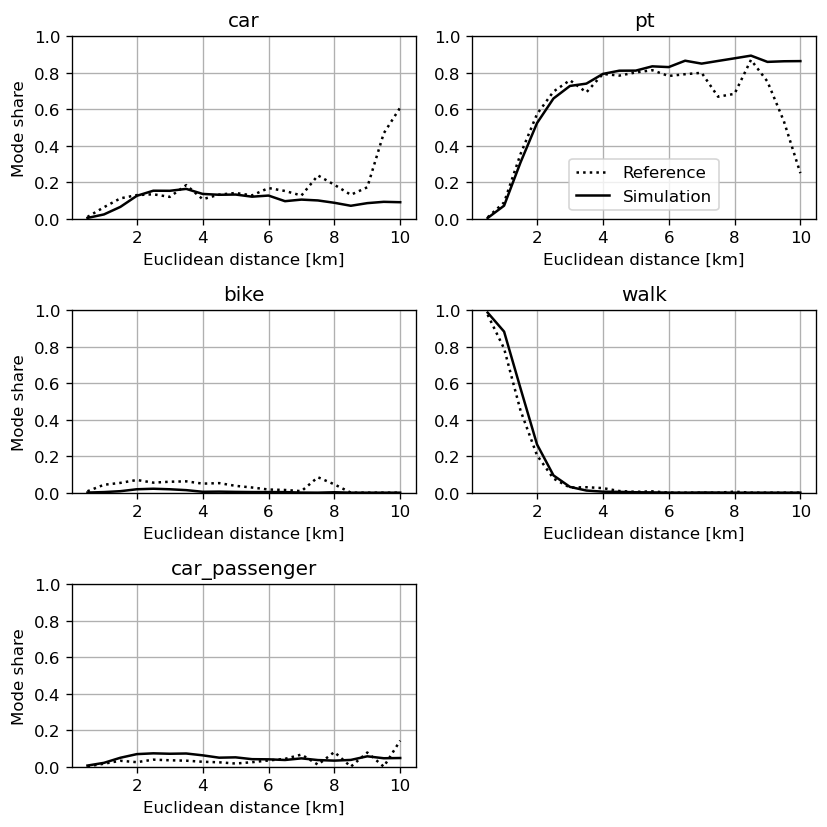

In [61]:
plt.figure(figsize = (7, 7), dpi = 120)
modes = ["car", "pt", "bike", "walk", "car_passenger"]

distance_classes = np.arange(1, 21 if filter_mode == "inside" else 41) * 500

for index, mode in enumerate(modes):
    plt.subplot(3, 2, index + 1)
    
    reference_class_counts = [df_reference[df_reference["distance_class"] == k]["weight"].sum() for k in range(len(distance_classes))]
    simulation_class_counts = [np.sum(df_simulation["distance_class"] == k) for k in range(len(distance_classes))]
    
    reference_mode_counts = [df_reference[(df_reference["distance_class"] == k) & (df_reference["mode"] == mode)]["weight"].sum() for k in range(len(distance_classes))]
    simulation_mode_counts = [np.sum((df_simulation["distance_class"] == k) & (df_simulation["mode"] == mode)) for k in range(len(distance_classes))]
    
    reference_mode_counts = np.array(reference_mode_counts) / np.maximum(1, np.array(reference_class_counts))
    simulation_mode_counts = np.array(simulation_mode_counts) / np.maximum(1, np.array(simulation_class_counts))
    
    #plt.bar(np.arange(len(distance_classes)), simulation_mode_counts, width = 0.4, color = "k", label = "Simulation", align = "edge")
    #plt.bar(np.arange(len(distance_classes)) + 0.4, reference_mode_counts, width = 0.4, color = "#cccccc", label = "Reference", align = "edge")
    
    plt.plot(distance_classes, reference_mode_counts, color = "k", label = "Reference", linestyle = ":")
    plt.plot(distance_classes, simulation_mode_counts, color = "k", label = "Simulation")
    
    #plt.gca().xaxis.set_major_locator(tck.FixedLocator(0.4 + np.arange(len(distance_classes))))
    #plt.gca().xaxis.set_major_formatter(tck.FixedFormatter([
    #    str(x / 1000) for x in distance_classes
    #]))
    
    plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 1e-3,)
    ))
    
    plt.xlabel("Euclidean distance [km]")
    
    plt.grid()
    plt.gca().set_axisbelow(True)
    #plt.gca().xaxis.grid(alpha = 0.0)
    
    plt.title(mode)
    if mode == "pt":
        plt.legend(loc = "best")
   
    if index % 2 == 0:
        plt.ylabel("Mode share")
        
    if mode == "car" and filter_mode == "inside":
        plt.ylim([None, 0.3])
        
    plt.ylim([0.0, 1.0])
        
plt.tight_layout()
plt.savefig("calibration_mode_shares.png")
plt.show()
plt.close()

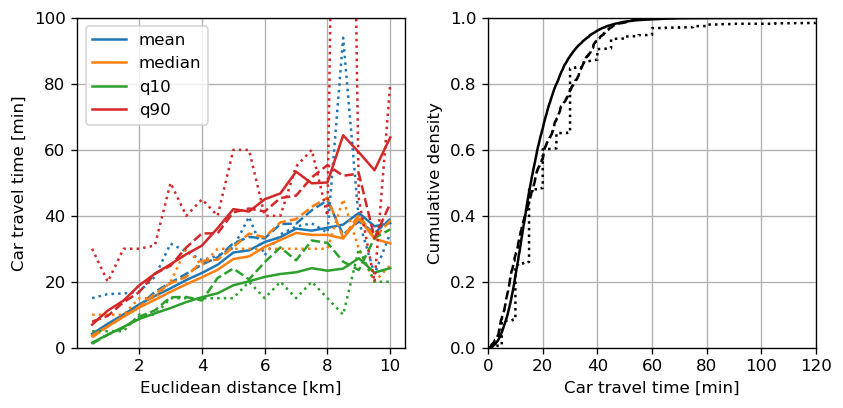

In [62]:
plt.figure(figsize = (7, 3.5), dpi = 120)
distance_classes = np.arange(1, 21 if filter_mode == "inside" else 41) * 500 

# Figure 1: Travel time by Euclidean distance
plt.subplot(1, 2, 1)

for slot_index, slot in enumerate(["mean", "median", "q10", "q90"]):
    reference_mean = []
    routed_mean = []
    simulation_mean = []

    for k in range(len(distance_classes)):
        df_class = df_reference[
            (df_reference["mode"] == "car") & (df_reference["distance_class"] == k)
        ]

        #reference_mean.append(
        #    (df_class["travel_time"] * df_class["weight"]).sum() / df_class["weight"].sum()
        #)

        values = df_class["travel_time"].values
        weights = df_class["weight"].values
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]
        cdf = np.cumsum(weights)
        cdf /= cdf[-1]
        weights /= np.sum(weights)

        if slot == "mean":
            reference_mean.append(np.sum(weights * values))
        else:
            q = dict(median = 0.5, q90 = 0.9, q10 = 0.1)[slot]
            reference_mean.append(values[np.count_nonzero(cdf < q)])
            
        # ---

        values = df_class["routed_travel_time"].values
        weights = df_class["weight"].values
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]
        cdf = np.cumsum(weights)
        cdf /= cdf[-1]
        weights /= np.sum(weights)

        if slot == "mean":
            routed_mean.append(np.sum(weights * values))
        else:
            q = dict(median = 0.5, q90 = 0.9, q10 = 0.1)[slot]
            routed_mean.append(values[np.count_nonzero(cdf < q)])

        df_class = df_simulation[
            (df_simulation["mode"] == "car") & (df_simulation["distance_class"] == k)
        ]

        #simulation_mean.append(
        #    (df_class["travel_time"] * df_class["weight"]).sum() / df_class["weight"].sum()
        #)
        
        values = df_class["travel_time"].values
        
        if len(values) > 0:
            weights = df_class["weight"].values
            sorter = np.argsort(values)
            values = values[sorter]
            weights = weights[sorter]
            cdf = np.cumsum(weights)
            cdf /= cdf[-1]
            weights /= np.sum(weights)

            if slot == "mean":
                simulation_mean.append(np.sum(weights * values))
            else:
                q = dict(median = 0.5, q90 = 0.9, q10 = 0.1)[slot]
                simulation_mean.append(values[np.count_nonzero(cdf < q)])
                
        else:
            simulation_mean.append(np.nan)

    plt.plot(distance_classes * 1e-3, np.array(reference_mean) / 60, linestyle = ":", color = "C%d" % slot_index)
    plt.plot(distance_classes * 1e-3, np.array(routed_mean) / 60, linestyle = "--", color = "C%d" % slot_index)
    plt.plot(distance_classes * 1e-3, np.array(simulation_mean) / 60, linestyle = "-", color = "C%d" % slot_index, label = slot)

plt.ylim([0, 100])
plt.grid()
plt.xlabel("Euclidean distance [km]")
plt.ylabel("Car travel time [min]")
plt.legend(loc = "best")

# Figure 2: CDF of travel time
plt.subplot(1, 2, 2)

f_reference = df_reference["mode"] == "car"
weights = df_reference[f_reference]["weight"].values
values = df_reference[f_reference]["travel_time"].values

sorter = np.argsort(values)
weights = weights[sorter]
values = values[sorter]
cdf = np.cumsum(weights)

plt.plot(values / 60, cdf / cdf[-1], 'k:')

f_reference = df_reference["mode"] == "car"
weights = df_reference[f_reference]["weight"].values
values = df_reference[f_reference]["routed_travel_time"].values

sorter = np.argsort(values)
weights = weights[sorter]
values = values[sorter]
cdf = np.cumsum(weights)

plt.plot(values / 60, cdf / cdf[-1], 'k--')

f_simulation = df_simulation["mode"] == "car"
weights = df_simulation[f_simulation]["weight"].values
values = df_simulation[f_simulation]["travel_time"].values

sorter = np.argsort(values)
weights = weights[sorter]
values = values[sorter]
cdf = np.cumsum(weights)

plt.plot(values / 60, cdf / cdf[-1], 'k-')

plt.xlim([0, 120])
plt.ylim([0.0, 1.0])
plt.grid()

plt.xlabel("Car travel time [min]")
plt.ylabel("Cumulative density")

plt.tight_layout()
plt.savefig("calibration_travel_times.png")
plt.show()
plt.close()

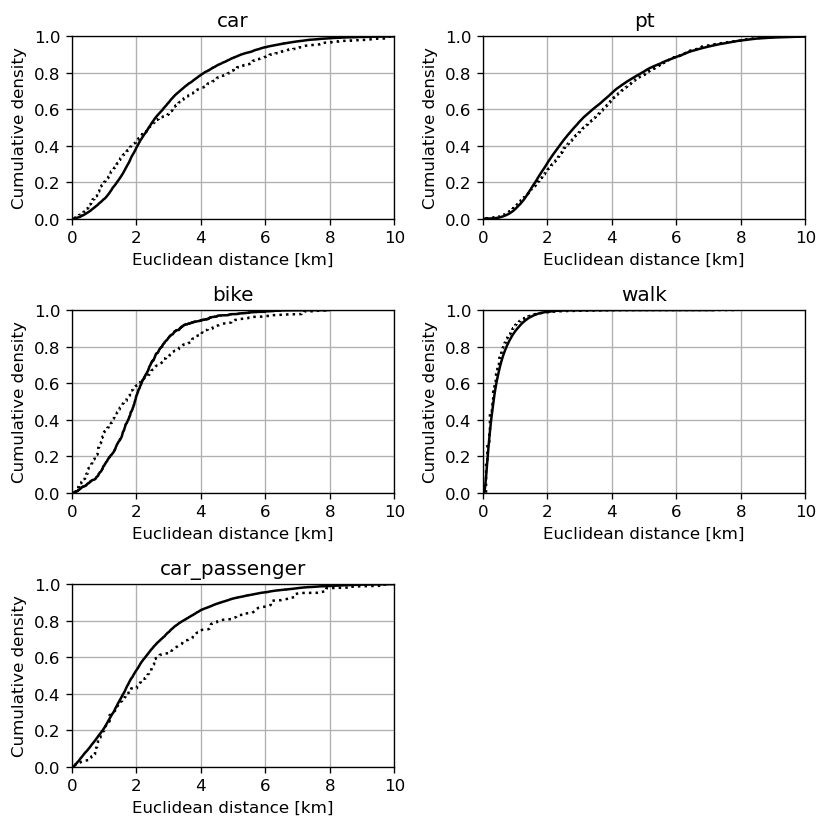

In [63]:
plt.figure(figsize = (7, 7), dpi = 120)

for index, mode in enumerate(modes):
    plt.subplot(3, 2, index + 1)
    
    f_reference = df_reference["mode"] == mode
    weights = df_reference[f_reference]["weight"].values
    values = df_reference[f_reference]["euclidean_distance"].values

    sorter = np.argsort(values)
    weights = weights[sorter]
    values = values[sorter]
    cdf = np.cumsum(weights)

    plt.plot(values * 1e-3, cdf / cdf[-1], 'k:')

    f_simulation = df_simulation["mode"] == mode
    weights = df_simulation[f_simulation]["weight"].values
    values = df_simulation[f_simulation]["crowfly_distance"].values

    sorter = np.argsort(values)
    weights = weights[sorter]
    values = values[sorter]
    cdf = np.cumsum(weights)

    plt.plot(values * 1e-3, cdf / cdf[-1], 'k-')

    plt.xlim([0, 10])
    plt.ylim([0.0, 1.0])
    plt.grid()

    plt.xlabel("Euclidean distance [km]")
    plt.ylabel("Cumulative density")
    plt.title(mode)

plt.tight_layout()
plt.show()
plt.close()

# Comparison of Movement data

In [64]:
df_iris = gpd.read_file("gis/CONTOURS-IRIS.shp").rename(columns = {
    "CODE_IRIS": "iris_id"
})

df_iris["departement"] = df_iris["INSEE_COM"].astype(str).str[:2]
df_iris = df_iris[df_iris["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

df_iris = df_iris[["iris_id", "geometry"]]
df_iris["iris_id"] = df_iris["iris_id"].astype(str)
df_iris = df_iris.set_index("iris_id")

In [65]:
df_simulation_tt = df_simulation.copy()

df_simulation_tt = df_simulation_tt[df_simulation_tt["mode"] == "car"][[
    "origin_x", "origin_y", "destination_x", "destination_y", "travel_time", "start_time"
]]

df_simulation_tt["travel_time_min"] = df_simulation_tt["travel_time"] / 60
df_simulation_tt["hour"] = (df_simulation_tt["start_time"] // 3600).astype(int)

In [66]:
df_simulation_tt["origin_geometry"] = gpd.points_from_xy(df_simulation_tt["origin_x"], df_simulation_tt["origin_y"])
df_simulation_tt["destination_geometry"] = gpd.points_from_xy(df_simulation_tt["destination_x"], df_simulation_tt["destination_y"])

In [67]:
df_origin = gpd.GeoDataFrame(df_simulation_tt[["origin_geometry"]], 
    geometry = "origin_geometry", crs = "EPSG:2154")

df_origin = gpd.sjoin(df_origin, df_iris, op = "within").rename(columns = dict(index_right = "iris_id"))
df_simulation_tt["origin_iris_id"] = df_origin["iris_id"]

In [68]:
df_destination = gpd.GeoDataFrame(df_simulation_tt[["destination_geometry"]], 
    geometry = "destination_geometry", crs = "EPSG:2154")

df_destination = gpd.sjoin(df_destination, df_iris, op = "within").rename(columns = dict(index_right = "iris_id"))
df_simulation_tt["destination_iris_id"] = df_destination["iris_id"]

In [69]:
df_simulation_tt = df_simulation_tt[["origin_iris_id", "destination_iris_id", "hour", "travel_time_min"]]
df_simulation_tt = df_simulation_tt.dropna()

In [70]:
df_simulation_tt["origin_iris_id"] = df_simulation_tt["origin_iris_id"].astype(int).astype(str)
df_simulation_tt["destination_iris_id"] = df_simulation_tt["destination_iris_id"].astype(int).astype(str)

df_simulation_od = df_simulation_tt.groupby(["origin_iris_id", "destination_iris_id", "hour"])[
    "travel_time_min"].mean().reset_index()

In [71]:
df_reference_tt = pd.read_csv("egt/localized_car_trips.csv", sep = ";")

df_reference_tt = df_reference_tt[[
  "origin_x", "origin_y", "destination_x", "destination_y", "routed_travel_time_min", "mode", "departure_time"
]]

df_reference_tt = df_reference_tt[df_reference_tt["mode"] == "car"]

df_reference_tt["origin_geometry"] = gpd.points_from_xy(df_reference_tt["origin_x"], df_reference_tt["origin_y"])
df_reference_tt["destination_geometry"] = gpd.points_from_xy(df_reference_tt["destination_x"], df_reference_tt["destination_y"])

In [72]:
df_origin = gpd.GeoDataFrame(df_reference_tt[["origin_geometry"]], 
    geometry = "origin_geometry", crs = "EPSG:2154")

df_origin = gpd.sjoin(df_origin, df_iris, op = "within").rename(columns = dict(index_right = "iris_id"))
df_reference_tt["origin_iris_id"] = df_origin["iris_id"]

In [73]:
df_destination = gpd.GeoDataFrame(df_reference_tt[["destination_geometry"]], 
    geometry = "destination_geometry", crs = "EPSG:2154")

df_destination = gpd.sjoin(df_destination, df_iris, op = "within").rename(columns = dict(index_right = "iris_id"))
df_reference_tt["destination_iris_id"] = df_destination["iris_id"]

In [74]:
df_reference_tt["hour"] = (df_reference_tt["departure_time"] // 3600).astype(int)

In [75]:
df_reference_od = df_reference_tt.groupby(["origin_iris_id", "destination_iris_id", "hour"])[
    "routed_travel_time_min"].mean().reset_index()

In [76]:
df_bing_od = df_reference_od.copy()
#df_here_od = df_reference_od.copy()

In [ ]:
df_uber = pd.read_csv("/home/shoerl/Downloads/paris-iris-2019-2-OnlyWeekdays-HourlyAggregate.csv")

df_uber = df_uber.rename(columns = {
    "sourceid": "origin_id",
    "dstid": "destination_id",
    "hod": "hour",
    "mean_travel_time": "uber_travel_time_min"
})

df_uber["uber_travel_time_min"] = df_uber["uber_travel_time_min"] / 60

df_uber = df_uber[[
    "origin_id", "destination_id", "hour", "uber_travel_time_min"
]]

In [ ]:
df_uber_iris = gpd.read_file("/home/shoerl/Downloads/paris_iris.json").rename(columns = {
    "MOVEMENT_ID": "zone_id"
})[["zone_id", "geometry"]].to_crs(dict(init = "epsg:2154"))

df_uber_iris["zone_id"] = df_uber_iris["zone_id"].astype(np.int64)

df_uber_iris["geometry"] = df_uber_iris["geometry"].centroid

df_uber_iris = gpd.sjoin(df_uber_iris, df_iris, op = "within").rename(columns = dict(
    index_right = "iris_id")).drop_duplicates("iris_id")

df_uber_iris = df_uber_iris[["zone_id", "iris_id"]]

In [ ]:
df_uber = pd.merge(df_uber, df_uber_iris.rename(columns = {
    "zone_id": "origin_id", "iris_id": "origin_iris_id"
}), on = "origin_id")

df_uber = pd.merge(df_uber, df_uber_iris.rename(columns = {
    "zone_id": "destination_id", "iris_id": "destination_iris_id"
}), on = "destination_id")

In [ ]:
df_uber = df_uber[["origin_iris_id", "destination_iris_id", "hour", "uber_travel_time_min"]]

In [ ]:
df_merge_bing = pd.merge(df_bing_od, df_uber, on = [
    "origin_iris_id", "destination_iris_id", "hour"
])

In [ ]:
#df_merge_here = pd.merge(df_here_od, df_uber, on = [
#    "origin_iris_id", "destination_iris_id", "hour"
#])

In [ ]:
df_merge_simulation = pd.merge(df_simulation_od, df_uber, on = [
    "origin_iris_id", "destination_iris_id", "hour"
])

In [ ]:
plt.figure(figsize = (10,4), dpi = 120)

plt.subplot(1,2,1)

f = np.ones(len(df_merge_bing), dtype = bool)
#f = df_merge_bing["origin_iris_id"].str.startswith("75") & df_merge_bing["destination_iris_id"].str.startswith("75")

plt.plot(
    df_merge_bing[f]["uber_travel_time_min"], df_merge_bing[f]["routed_travel_time_min"], '.', markersize = 1,
    label = "Bing"
)

plt.title("Mean travel times per IRIS OD pair and hour")
plt.xlabel("Uber Movement travel time [min]")
plt.ylabel("Bing travel time [min]")
plt.grid()

plt.xlim([0, 80])
plt.ylim([0, 80])

plt.plot([0, 70], [0, 70], 'k--')

plt.subplot(1,2,2)

f = np.ones(len(df_merge_simulation), dtype = bool)
#f = df_merge_simulation["origin_iris_id"].str.startswith("75") & df_merge_simulation["destination_iris_id"].str.startswith("75")

plt.plot(
    df_merge_simulation[f]["uber_travel_time_min"], df_merge_simulation[f]["travel_time_min"], '.', markersize = 1
)

plt.title("Mean travel times per IRIS OD pair and hour")
plt.xlabel("Uber Movement travel time [min]")
plt.ylabel("MATSim travel time [min]")
plt.grid()

plt.xlim([0, 80])
plt.ylim([0, 80])

plt.plot([0, 70], [0, 70], 'k--')